# Marvel Rivals 크롤링

1. 게임 전체 리뷰
    - 수집 대상
        - 닉네임, 작성일, 본문, 추천 여부, 플레이 시간
    - 스크롤 내리면서 리뷰 한 개 섹션 단위로 파싱
    - 중복된 댓글 반복 시 종료
    - 500개마다 중간저장
    
2. 스팀 뉴스 업데이트 수집
    - 수집 대상
        - 업데이트 페이지에서 각 세부 페이지 경로 수집
        - 이후 제목, 게시일, 유형, 본문, 좋아요 수, 댓글 주소 수집

3. 인스타그램 수집
    - 수집 대상
        - 인스타그램 게시물 링크
        - 게시일, 좋아요 수, 본문, 게시물 URL
    - 로그인 후 프로필 페이지 진입
    - 스크롤 다운하며 링크 수집
    - 2024-07-01 이전 게시물 발견 시 루프 중단

4. 유튜브 수집
    - 수집 대상
        - 제목, 동영상 URL, 조회수 텍스트, 게시일
    - 링크 이동 후 '동영상' 탭 클릭
    - 페이지 최하단까지 스크롤 후 파싱
    - URL 하나씩 열어서 좋아요 수, 댓글 수 파싱
    - URL을 기준으로 맵핑하여 하나의 데이터프레임으로 완성 후 저장

## 1. 게임 전체 리뷰

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
import time
import pandas as pd

# 셀레니움 설정
options = Options()
options.add_argument("--start-maximized")
options.add_experimental_option("detach", True)

driver = webdriver.Chrome(options=options)

# URL 진입
url = "https://steamcommunity.com/app/2767030/reviews/?p=1&browsefilter=trendthreemonths&filterLanguage=all"
driver.get(url)
time.sleep(3)

SCROLL_PAUSE = 2
results = []
last_height = driver.execute_script("return document.body.scrollHeight")
last_seen_content = None
seen_repeat_count = 0

save_interval = 500
save_count = 1

while True:
    # 리뷰 카드 수집
    cards = driver.find_elements(By.CLASS_NAME, "apphub_Card")

    for card in cards[len(results):]:
        try:
            nickname_link = card.find_element(By.CSS_SELECTOR, ".apphub_friend_block_container a").get_attribute("href")
        except:
            nickname_link = None

        try:
            date = card.find_element(By.CLASS_NAME, "date_posted").text.replace("게시 일시: ", "").strip()
        except:
            date = None

        try:
            content = card.find_element(By.CLASS_NAME, "apphub_CardTextContent").text.strip()
        except:
            content = None

        try:
            recommendation = card.find_element(By.CLASS_NAME, "title").text.strip()
        except:
            recommendation = None

        try:
            playtime = card.find_element(By.CLASS_NAME, "hours").text.strip()
        except:
            playtime = None

        # 종료 조건: 동일 댓글 반복 감지
        if content == last_seen_content:
            seen_repeat_count += 1
            if seen_repeat_count >= 3:
                print("\n동일 댓글 3회 반복 감지. 크롤링 종료.")
                break
        else:
            seen_repeat_count = 0
            last_seen_content = content

        row = {
            "닉네임": nickname_link,
            "작성일": date,
            "본문": content,
            "추천 여부": recommendation,
            "플레이 시간": playtime
        }
        results.append(row)

        # 실시간 출력
        print(f"\n닉네임: {nickname_link}")
        print(f"작성일: {date}")
        print(f"추천여부: {recommendation}")
        print(f"플레이 시간: {playtime}")
        print(f"본문: {content[:100]}{'...' if content and len(content) > 100 else ''}")

        # 중간 저장
        if len(results) % save_interval == 0:
            temp_df = pd.DataFrame(results)
            temp_df.to_csv(f"Marvel Rivals_reviews_temp_{save_count}.csv", index=False, encoding="utf-8-sig")
            print(f"\n 중간 저장 완료: Marvel Rivals_reviews_temp_{save_count}.csv ({len(results)}개)")
            save_count += 1

    # 중복 종료 처리
    if seen_repeat_count >= 3:
        break

    # 스크롤 다운
    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    time.sleep(5)  # 스크롤 후 5초 대기

    new_height = driver.execute_script("return document.body.scrollHeight")
    if new_height == last_height:
        print("\n더 이상 로드할 내용 없음. 종료합니다.")
        break
    last_height = new_height


# 최종 저장
df = pd.DataFrame(results)
df.to_csv("30-0. Marvel Rivals_reviews.csv", index=False, encoding="utf-8-sig")
print(f"\n 크롤링 완료! 총 리뷰 수: {len(df)}개")
print("저장 완료: 30-0. Marvel Rivals_reviews.csv")

## 2. 스팀 뉴스 업데이트 수집

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
import pandas as pd

# ▶ URL 설정
url = "https://store.steampowered.com/news/app/2767030?updates=true"

# ▶ 드라이버 설정
options = Options()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# ▶ 페이지 열기
driver.get(url)
time.sleep(3)

# ▶ 수집용 set
collected_urls = set()
results = []

# ▶ 천천히 스크롤하며 수집
scroll_count = 0
max_scrolls = 50
no_new_count = 0

while scroll_count < max_scrolls and no_new_count < 3:
    soup = BeautifulSoup(driver.page_source, "html.parser")

    news_blocks = soup.find_all("div", class_="_398u23KF15gxmeH741ZSyL")

    found_this_round = 0

    for block in news_blocks:
        a_tag = block.find("a", class_="Focusable")
        if a_tag:
            href = a_tag.get("href")
            if href and href not in collected_urls:
                full_url = "https://store.steampowered.com" + href
                collected_urls.add(href)
                results.append({"링크": full_url})
                print(f"📝 [{len(results)}] {full_url}")
                found_this_round += 1

    if found_this_round == 0:
        no_new_count += 1
    else:
        no_new_count = 0

    # 스크롤 다운
    driver.execute_script("window.scrollBy(0, 1500);")
    scroll_count += 1
    time.sleep(2.5)

# ▶ 저장
updatelink_df = pd.DataFrame(results)
updatelink_df['링크'] = updatelink_df["링크"].str.extract(r"(\/view\/\d+)")
updatelink_df.to_csv("30-1. Marvel Rivals_links.csv", index=False, encoding="utf-8-sig")
print(f"\n✅ 총 {len(updatelink_df)}개 뉴스 링크 저장 완료 → 30-1. Marvel Rivals_links.csv")

driver.quit()


📝 [1] https://store.steampowered.com/news/app/2767030/view/541115924558644672
📝 [2] https://store.steampowered.com/news/app/2767030/view/541115924558644721
📝 [3] https://store.steampowered.com/news/app/2767030/view/541115291253342903
📝 [4] https://store.steampowered.com/news/app/2767030/view/541115291253342217
📝 [5] https://store.steampowered.com/news/app/2767030/view/612045811444876070
📝 [6] https://store.steampowered.com/news/app/2767030/view/612045811444875935
📝 [7] https://store.steampowered.com/news/app/2767030/view/523099623582074625
📝 [8] https://store.steampowered.com/news/app/2767030/view/541112753868243356
📝 [9] https://store.steampowered.com/news/app/2767030/view/541112753868243080
📝 [10] https://store.steampowered.com/news/app/2767030/view/541112120139326659
📝 [11] https://store.steampowered.com/news/app/2767030/view/541111741871818506
📝 [12] https://store.steampowered.com/news/app/2767030/view/635686713588449858
📝 [13] https://store.steampowered.com/news/app/2767030/view/6

In [ ]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import pandas as pd
import time

# ▶ 드라이버 세팅
options = Options()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# ▶ URL 베이스
base_url = "https://store.steampowered.com/news/app/2767030"

# ▶ update_df["링크"]에 '/view/숫자' 형태가 들어있다고 가정
# 예시용 (실제에는 update_df = pd.read_csv(...)로 불러와야 함)
# update_df = pd.read_csv("steam_news_links_stable.csv")
# update_df["링크"] = update_df["링크"].str.extract(r"(\/view\/\d+)")

results = []

for i, update_link in enumerate(updatelink_df["링크"], 1):
    full_url = base_url + update_link
    print(f"\n🌐 [{i}] 크롤링 중: {full_url}")

    try:
        driver.get(full_url)
        time.sleep(3)
        soup = BeautifulSoup(driver.page_source, "html.parser")

        # ✅ 제목
        title_tag = soup.select_one("div._3z2NYCkFizMu4fMvWTIBUG div.TqEPC9bhvVpZ1rb3Z8Mbd")
        title = title_tag.text.strip() if title_tag else ""

        # ✅ 게시일
        date_tag = soup.select_one("div._3IxVZE9uydjh3cA9kmtnk7 div._2KsEbGy9kiSDeQpcqEc9DG div._1Maw_Rw6sOKYC1KkOI1xM")
        date = date_tag.text.strip() if date_tag else ""

        # ✅ 유형
        type_tag = soup.select_one("div._3phfIcOe_STA7hSoFfIxlE")
        type_text = type_tag.text.strip() if type_tag else ""

        # ✅ 본문
        body_tag = soup.select_one("div.EventDetailsBody.A_A2B6fTn_MPLlGCmsLtd")
        body = body_tag.text.strip() if body_tag else ""

        # ✅ 좋아요 수
        like_tag = soup.select_one("div._9x4Z7eMgdwfAVMr16ZaJ0 div._3Kelh1-_v6xHfRjF68n7NB div._3csl-MPe-hKuT8hQpOqEG5")
        likes = like_tag.text.strip() if like_tag else ""

        # ✅ 토론 주소
        comment_tag = soup.select_one("div._16xC0mtOWoLbvSQbmo_ycv a.Focusable")
        comment_link = comment_tag["href"] if comment_tag else ""

        # ▶ 저장
        results.append({
            "링크": full_url,
            "제목": title,
            "게시일": date,
            "유형": type_text,
            "본문": body,
            "좋아요": likes,
            "댓글 주소": comment_link
        })

        print(f"📝 제목: {title} | 게시일: {date} | 좋아요: {likes} | 본문: {body[:20]}")

    except Exception as e:
        print(f"❌ [{i}] 오류 발생: {e}")
        continue

driver.quit()

# ▶ DataFrame 저장
update_df = pd.DataFrame(results)
update_df.to_csv("30-2. Marvel Rivals_update_details.csv", index=False, encoding="utf-8-sig")
print(f"\n✅ 총 {len(update_df)}개 뉴스 상세 정보 저장 완료 → 30-2. Marvel Rivals_update_details.csv")



🌐 [1] 크롤링 중: https://store.steampowered.com/news/app/2767030/view/541115924558644672
📝 제목: Marvel Rivals Version 20250912 Patch Notes: Season 4 Heart of the Dragon | 게시일: Posted Thu, September 11, 2025 @4:00 PM KST | 좋아요: 2,019 | 본문: Greetings, Rivals!Se

🌐 [2] 크롤링 중: https://store.steampowered.com/news/app/2767030/view/541115924558644721
📝 제목: Marvel Rivals Version 20250912 Balance Post | 게시일: Posted Fri, September 5, 2025 @2:03 AM KST | 좋아요: 1,231 | 본문: The Marvel Rivals un

🌐 [3] 크롤링 중: https://store.steampowered.com/news/app/2767030/view/541115291253342903
📝 제목: Marvel Rivals Version 20250904 Patch Notes | 게시일: Posted Wed, September 3, 2025 @3:25 AM KST | 좋아요: 632 | 본문: Greetings, Rivals!We

🌐 [4] 크롤링 중: https://store.steampowered.com/news/app/2767030/view/541115291253342217
📝 제목: Marvel Rivals Version 20250828 Patch Notes | 게시일: Posted Thu, August 28, 2025 @6:00 PM KST | 좋아요: 849 | 본문: Greetings, Rivals!We

🌐 [5] 크롤링 중: https://store.steampowered.com/news/app/2767030/view/6120458

## 3. 인스타그램 수집

In [ ]:
from selenium import webdriver 
from selenium.webdriver.common.by import By 
from selenium.webdriver.chrome.options import Options 
from selenium.webdriver.support.ui import WebDriverWait 
from selenium.webdriver.support import expected_conditions as EC 
from selenium.webdriver.common.keys import Keys 
import time 
import pandas as pd 
from datetime import datetime 
from bs4 import BeautifulSoup 

# === 1. 사용자 계정 정보 === 
INSTAGRAM_ID = "ddukbbangii_i"
INSTAGRAM_PW = "qawsed123" 

# === 2. Chrome 드라이버 설정 === 
options = Options() 
options.add_argument("--start-maximized") 
driver = webdriver.Chrome(options=options) 

# === 3. 인스타그램 로그인 페이지로 이동 === 
driver.get("https://www.instagram.com/") 
time.sleep(5) 

# === 4. 로그인 === 
try: 
    id_input = driver.find_element(By.XPATH, '//*[@id="loginForm"]/div[1]/div[1]/div/label/input') 
    id_input.send_keys(INSTAGRAM_ID) 
    time.sleep(1) 
    pw_input = driver.find_element(By.XPATH, '//*[@id="loginForm"]/div[1]/div[2]/div/label/input') 
    pw_input.send_keys(INSTAGRAM_PW) 
    time.sleep(1) 
    login_btn = driver.find_element(By.XPATH, '//*[@id="loginForm"]/div[1]/div[3]/button') 
    login_btn.click() 
    print("🔐 로그인 시도 중...") 
    time.sleep(7) 
except Exception as e: 
    print(f"❌ 로그인 실패: {e}") 

# === 5. 타겟 페이지 이동 === 
target_url = "https://www.instagram.com/marvelrivals/" 
driver.get(target_url) 
time.sleep(5) 

# === 6. 게시물 URL 수집 함수 === 
def collect_post_urls(max_posts=200): 
    """스크롤하면서 게시물 URL들을 수집""" 
    print(f"📜 최대 {max_posts}개 게시물 URL 수집 중...") 
    collected_urls = set() # 중복 방지 
    last_height = driver.execute_script("return document.body.scrollHeight") 
    no_new_posts_count = 0 
    
    while len(collected_urls) < max_posts and no_new_posts_count < 3: 
        # 현재 페이지에 있는 모든 게시물 링크 찾기 
        try: 
            # 여러 선택자로 시도 
            selectors = [ 
                "a.x1i10hfl[href*='/p/']", 
                "a[href*='/p/']", 
            ] 
            current_posts = [] 
            for selector in selectors: 
                try: 
                    posts = driver.find_elements(By.CSS_SELECTOR, selector) 
                    if posts: 
                        current_posts = posts 
                        break 
                except: 
                    continue 

            # URL 수집 
            before_count = len(collected_urls) 
            for post in current_posts: 
                try: 
                    href = post.get_attribute("href") 
                    if href and ("/p/" in href or "/reel/" in href): 
                        collected_urls.add(href) 
                except: 
                    continue 

            after_count = len(collected_urls) 
            new_found = after_count - before_count 
            print(f"📊 현재까지 수집된 URL: {len(collected_urls)}개 (새로 발견: {new_found}개)") 

            if new_found == 0: 
                no_new_posts_count += 1 
                print(f"⚠️ 새로운 게시물 없음 ({no_new_posts_count}/3)") 
            else: 
                no_new_posts_count = 0 

            # 스크롤 
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") 
            time.sleep(4) 

            # 페이지 높이 확인 
            new_height = driver.execute_script("return document.body.scrollHeight") 
            if new_height == last_height: 
                no_new_posts_count += 1 
                print(f"⚠️ 페이지 높이 변화 없음 ({no_new_posts_count}/3)") 
            else: 
                last_height = new_height 
                
        except Exception as e: 
            print(f"❌ URL 수집 중 오류: {e}") 
            break 

    print(f"✅ URL 수집 완료: 총 {len(collected_urls)}개") 
    return list(collected_urls) 

# === 7. 게시물 URL 수집 === 
post_urls = collect_post_urls(max_posts=100) 
if not post_urls: 
    print("❌ 게시물 URL을 찾을 수 없습니다.") 
    driver.quit() 
    exit() 

# === 8. 각 게시물 방문하여 데이터 수집 === 
results = [] 
stop_date = datetime.strptime("2024.07.01", "%Y.%m.%d") 
print(f"\n🔄 {len(post_urls)}개 게시물 데이터 수집 시작...") 

for i, post_url in enumerate(post_urls, 1): 
    try: 
        print(f"📸 [{i}/{len(post_urls)}] 게시물 처리 중: {post_url}") 
        
        # 게시물 페이지로 직접 이동 
        driver.get(post_url) 
        time.sleep(5) 

        # 본문 수집 (실제 게시물 페이지 구조에 맞게 수정)
        content = ""
        try:
            print(f"🔍 본문 수집 시도 중...")
            
            # 실제 게시물 페이지의 구조에 맞는 선택자들
            content_selectors = [
                # 제공해주신 실제 구조
                "div.html-div.xdj266r.x14z9mp.xat24cr.x1lziwak.xexx8yu.xyri2b.x18d9i69.x1c1uobl.x9f619.xjbqb8w.x78zum5.x15mokao.x1ga7v0g.x16uus16.xbiv7yw.x1uhb9sk.x1plvlek.xryxfnj.x1iyjqo2.x2lwn1j.xeuugli.x1q0g3np.xqjyukv.x1qjc9v5.x1oa3qoh.x1nhvcw1 span.x193iq5w.xeuugli.x13faqbe.x1vvkbs.xt0psk2.x1i0vuye.xvs91rp.xo1l8bm.x5n08af.x10wh9bi.xpm28yp.x8viiok.x1o7cslx.x126k92a",
                
                # 간단한 버전들
                "div.html-div span.x193iq5w.xeuugli.x13faqbe.x1vvkbs.xt0psk2",
                "span.x193iq5w.xeuugli.x13faqbe.x1vvkbs.xt0psk2.x1i0vuye.xvs91rp.xo1l8bm.x5n08af.x10wh9bi.xpm28yp.x8viiok.x1o7cslx.x126k92a",
                "span.x193iq5w.xeuugli.x13faqbe.x1vvkbs.xt0psk2",
                "span.xt0psk2.x193iq5w",
                
                # 주요 클래스만으로
                "span.xt0psk2",
                "span.x193iq5w",
                "span.xeuugli.xt0psk2",
                
                # div.html-div 내부 모든 span
                "div.html-div span",
                "div.xdj266r span",
                
                # 더 광범위한 검색
                "div[class*='html-div'] span[class*='xt0psk2']",
                "div[class*='xdj266r'] span[class*='x193iq5w']",
            ]
            
            for selector in content_selectors:
                try:
                    print(f"  CSS 시도: {selector}")
                    elements = driver.find_elements(By.CSS_SELECTOR, selector)
                    print(f"    발견된 요소 수: {len(elements)}개")
                    
                    for i, element in enumerate(elements):
                        text = element.text.strip()
                        print(f"    [{i+1}] 텍스트: {text[:80]}...")
                        
                        # 본문 조건 체크
                        if (text and 
                            len(text) > 10 and 
                            text != "..." and
                            "좋아요" not in text and 
                            "like" not in text.lower() and
                            "팔로우" not in text and 
                            "follow" not in text.lower() and
                            "댓글" not in text and 
                            "comment" not in text.lower() and
                            "공유" not in text and 
                            "저장" not in text and
                            "더 보기" not in text and
                            not text.replace(",", "").replace(".", "").replace("만", "").isdigit()):
                            
                            content = text
                            print(f"✅ 본문 발견! 선택자: {selector}")
                            print(f"   길이: {len(text)}자, 내용: {text[:100]}...")
                            break
                    
                    if content:
                        break
                        
                except Exception as e:
                    print(f"    CSS 실패: {e}")
                    continue
            
            # CSS로 못 찾으면 XPath로 시도
            if not content:
                print("🔍 XPath로 재시도...")
                xpath_selectors = [
                    # 클래스 기반 XPath
                    "//div[contains(@class, 'html-div')]//span[contains(@class, 'xt0psk2')]",
                    "//div[contains(@class, 'xdj266r')]//span[contains(@class, 'x193iq5w')]",
                    "//span[contains(@class, 'xt0psk2') and contains(@class, 'x193iq5w')]",
                    "//span[contains(@class, 'xt0psk2')]",
                    "//span[contains(@class, 'x193iq5w')]",
                    
                    # 긴 텍스트가 있는 span
                    "//span[string-length(text()) > 15]",
                    "//div[contains(@class, 'html-div')]//span[string-length(text()) > 15]",
                ]
                
                for xpath in xpath_selectors:
                    try:
                        print(f"  XPath 시도: {xpath}")
                        elements = driver.find_elements(By.XPATH, xpath)
                        print(f"    발견된 요소 수: {len(elements)}개")
                        
                        for i, element in enumerate(elements):
                            text = element.text.strip()
                            print(f"    [{i+1}] 텍스트: {text[:80]}...")
                            
                            if (text and 
                                len(text) > 15 and 
                                text != "..." and
                                "좋아요" not in text and 
                                "팔로우" not in text and
                                "댓글" not in text and
                                not text.replace(",", "").isdigit()):
                                
                                content = text
                                print(f"✅ XPath로 본문 발견!")
                                break
                        
                        if content:
                            break
                            
                    except Exception as e:
                        print(f"    XPath 실패: {e}")
                        continue
            
            # 마지막: 모든 span 요소 확인
            if not content:
                print("🔍 모든 span 요소 확인...")
                try:
                    all_spans = driver.find_elements(By.TAG_NAME, "span")
                    print(f"    총 {len(all_spans)}개의 span 요소 발견")
                    
                    for i, span in enumerate(all_spans):
                        try:
                            text = span.text.strip()
                            classes = span.get_attribute("class") or ""
                            
                            # 본문으로 보이는 긴 텍스트
                            if (text and 
                                len(text) > 20 and 
                                len(text) < 1000 and
                                text != "..." and
                                "좋아요" not in text and 
                                "팔로우" not in text and
                                "댓글" not in text and
                                ("xt0psk2" in classes or "x193iq5w" in classes or 
                                 "Step" in text or "Destiny" in text or "Nine" in text)):
                                
                                content = text
                                print(f"✅ span 탐색으로 본문 발견! 인덱스: {i+1}")
                                print(f"   클래스: {classes}")
                                print(f"   텍스트: {text[:100]}...")
                                break
                                
                        except Exception as e:
                            continue
                            
                except Exception as e:
                    print(f"  모든 span 확인 실패: {e}")
                    
        except Exception as e:
            print(f"❌ 본문 수집 전체 실패: {e}")
            content = ""
                    
        except Exception as e:
            print(f"⚠️ 본문 수집 실패: {e}")
            content = ""

        # 좋아요 수 수집 
        likes = "" 
        try: 
            # 여러 방법으로 좋아요 수 찾기 
            like_selectors = [ 
                "a[href*='liked_by']", 
                "span:contains('좋아요')", 
                "button span:contains('좋아요')", 
            ] 
            for selector in like_selectors: 
                try: 
                    if "contains" in selector: 
                        # XPath 사용 
                        xpath = f"//span[contains(text(), '좋아요')]" 
                        like_elem = driver.find_element(By.XPATH, xpath) 
                    else: 
                        like_elem = driver.find_element(By.CSS_SELECTOR, selector) 
                    likes = like_elem.text 
                    break 
                except: 
                    continue 

            # 좋아요 수를 찾지 못했을 때 숫자가 있는 span 찾기 
            if not likes: 
                try: 
                    spans = driver.find_elements(By.CSS_SELECTOR, "span") 
                    for span in spans: 
                        span_text = span.text.strip() 
                        if span_text and any(char.isdigit() for char in span_text): 
                            if "좋아요" in span_text or "like" in span_text.lower() or span_text.replace(',', '').replace('.', '').replace('만', '').isdigit(): 
                                likes = span_text 
                                break 
                except: 
                    pass 
        except: 
            likes = "" 

        # 게시일 수집 
        date_obj = None 
        try: 
            time_tag = WebDriverWait(driver, 5).until( 
                EC.presence_of_element_located((By.CSS_SELECTOR, "time")) 
            ) 
            date_text = time_tag.get_attribute("title") 
            if date_text: 
                # 한국어 날짜 형식 처리 
                date_text = date_text.replace("년 ", "-").replace("월 ", "-").replace("일", "") 
                date_obj = datetime.strptime(date_text, "%Y-%m-%d") 
                
                # 기준일 이전이면 종료 
                if date_obj < stop_date: 
                    print(f"🛑 기준일({stop_date.date()}) 이전 게시물 발견 → 종료") 
                    break 
        except Exception as e: 
            print(f"⚠️ 날짜 파싱 실패: {e}") 
            date_obj = None 

        print(f"✅ [{i}] 게시일: {date_obj.date() if date_obj else ''} | 좋아요: {likes} | 본문: {content[:30]}...") 
        
        results.append({ 
            "게시일": date_obj.date() if date_obj else "", 
            "좋아요 수": likes, 
            "본문": content, 
            "주소": post_url 
        }) 

        # 10개마다 진행 상황 출력 
        if i % 10 == 0: 
            print(f"🔄 {i}개 수집 완료") 
            
    except Exception as e: 
        print(f"⚠️ 게시물 {i} 처리 실패: {e}") 
        continue 

# === 9. 결과 저장 ===
try:
    insta_df = pd.DataFrame(results)
    insta_df.to_csv("30-3. Marvel Rivals_instagram_crawled.csv", index=False, encoding="utf-8-sig")
    print(f"\n✅ 저장 완료: 30-3. Marvel Rivals_instagram_crawled.csv (총 {len(insta_df)}개)")
except Exception as e:
    print(f"❌ 저장 실패: {e}")
finally:
    driver.quit()

🔐 로그인 시도 중...
📜 최대 100개 게시물 URL 수집 중...
📊 현재까지 수집된 URL: 6개 (새로 발견: 6개)
📊 현재까지 수집된 URL: 13개 (새로 발견: 7개)
📊 현재까지 수집된 URL: 17개 (새로 발견: 4개)
📊 현재까지 수집된 URL: 24개 (새로 발견: 7개)
📊 현재까지 수집된 URL: 31개 (새로 발견: 7개)
📊 현재까지 수집된 URL: 37개 (새로 발견: 6개)
📊 현재까지 수집된 URL: 42개 (새로 발견: 5개)
📊 현재까지 수집된 URL: 50개 (새로 발견: 8개)
📊 현재까지 수집된 URL: 55개 (새로 발견: 5개)
📊 현재까지 수집된 URL: 63개 (새로 발견: 8개)
📊 현재까지 수집된 URL: 71개 (새로 발견: 8개)
📊 현재까지 수집된 URL: 76개 (새로 발견: 5개)
📊 현재까지 수집된 URL: 82개 (새로 발견: 6개)
📊 현재까지 수집된 URL: 90개 (새로 발견: 8개)
📊 현재까지 수집된 URL: 95개 (새로 발견: 5개)
📊 현재까지 수집된 URL: 100개 (새로 발견: 5개)
✅ URL 수집 완료: 총 100개

🔄 100개 게시물 데이터 수집 시작...
📸 [1/100] 게시물 처리 중: https://www.instagram.com/marvelrivals/p/DMxv7sotJA3/
🔍 본문 수집 시도 중...
  CSS 시도: div.html-div.xdj266r.x14z9mp.xat24cr.x1lziwak.xexx8yu.xyri2b.x18d9i69.x1c1uobl.x9f619.xjbqb8w.x78zum5.x15mokao.x1ga7v0g.x16uus16.xbiv7yw.x1uhb9sk.x1plvlek.xryxfnj.x1iyjqo2.x2lwn1j.xeuugli.x1q0g3np.xqjyukv.x1qjc9v5.x1oa3qoh.x1nhvcw1 span.x193iq5w.xeuugli.x13faqbe.x1vvkbs.xt0psk2.x1i0vuye.xvs91rp.xo1l8bm

## 4. 유튜브 수집

In [7]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from bs4 import BeautifulSoup
import pandas as pd
import time

# --- 1. 크롬 드라이버 설정 ---
options = Options()
options.add_argument("--disable-gpu")
options.add_argument("--no-sandbox")
driver = webdriver.Chrome(options=options)

# --- 2. 유튜브 채널 열기 ---
driver.get("https://www.youtube.com/@MarvelRivals/videos")
time.sleep(3)

# --- 4. 영상 수집 ---
video_data = []
scroll_pause = 2
last_height = driver.execute_script("return document.documentElement.scrollHeight")
stop_crawling = False

while not stop_crawling:
    soup = BeautifulSoup(driver.page_source, "html.parser")
    video_items = soup.select("ytd-rich-item-renderer")

    for item in video_items[len(video_data):]:  # 중복 방지
        title_tag = item.select_one("#video-title")
        link_tag = item.select_one("a#video-title-link")
        meta_tags = item.select("span.inline-metadata-item")

        if title_tag and link_tag and len(meta_tags) > 1:
            title = title_tag.text.strip()
            url = "https://www.youtube.com" + link_tag["href"]
            posted = meta_tags[1].text.strip()
            views = meta_tags[0].text.strip()

            # 종료 조건: 게시일이 '1년 전'
            if "1년 전" in posted:
                print(f"🛑 게시일 '{posted}' → 크롤링 종료")
                stop_crawling = True
                break

            print(f"📹 {title} | {url} | {views} | {posted}")
            video_data.append({
                "제목": title,
                "URL": url,
                "조회수": views,
                "게시일": posted
            })

    # 스크롤 다운
    driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
    time.sleep(scroll_pause)
    new_height = driver.execute_script("return document.documentElement.scrollHeight")
    if new_height == last_height:
        break
    last_height = new_height

# --- 5. 브라우저 종료 ---
driver.quit()

# --- 6. CSV로 저장 ---
youtube_df = pd.DataFrame(video_data)
csv_path = "30-4. Marvel Rivals_youtube_crawled.csv"
youtube_df.to_csv(csv_path, index=False, encoding="utf-8-sig")
print(f"\n✅ 총 {len(youtube_df)}개 영상 저장 완료: {csv_path}")


📹 Season 4 Battle Pass: Fruit of Immortality | Official Trailer | Marvel Rivals | https://www.youtube.com/watch?v=D85112C9_O0 | 조회수 228만회 | 4일 전
📹 Angela: The Hand of Heven Descends | Character Reveal | Marvel Rivals | https://www.youtube.com/watch?v=WVc4uTJmKy4 | 조회수 544만회 | 10일 전
📹 Marvel Rivals: Season 4: Heart of Dragon // Dev Vision Vol. 09 | https://www.youtube.com/watch?v=dRUcdKzw6nQ | 조회수 158만회 | 11일 전
📹 Season 4: The Heart of the Dragon Official Trailer | Clashes unfold Sept 12, 2025 | Marvel Rivals | https://www.youtube.com/watch?v=67FVMNGMFXU | 조회수 507만회 | 11일 전
📹 Art Vision Vol. 04 // Heroic Essence: Crafting Character and Charisma | Marvel Rivals | https://www.youtube.com/watch?v=Dt-JPu8CboQ&pp=0gcJCckJAYcqIYzv | 조회수 32만회 | 3주 전
📹 Klyntar - Resource Rumble Trailer | New Game Mode | Marvel Rivals | https://www.youtube.com/watch?v=pGfp8UJDpdg | 조회수 70만회 | 3주 전
📹 Klyntar: Throne of Knull | Map Reveal | Marvel Rivals | https://www.youtube.com/watch?v=P44x3oxvhFY&pp=0gcJCckJAYc

In [3]:
youtube_df = pd.read_csv('30-4. Marvel Rivals_youtube_crawled.csv', encoding="utf-8-sig")
yturl_list = youtube_df['URL'].tolist()

In [4]:
yturl_list

['https://www.youtube.com/watch?v=D85112C9_O0',
 'https://www.youtube.com/watch?v=WVc4uTJmKy4',
 'https://www.youtube.com/watch?v=dRUcdKzw6nQ',
 'https://www.youtube.com/watch?v=67FVMNGMFXU',
 'https://www.youtube.com/watch?v=Dt-JPu8CboQ&pp=0gcJCckJAYcqIYzv',
 'https://www.youtube.com/watch?v=pGfp8UJDpdg',
 'https://www.youtube.com/watch?v=P44x3oxvhFY&pp=0gcJCckJAYcqIYzv',
 'https://www.youtube.com/watch?v=itWQ1bxYoYY',
 'https://www.youtube.com/watch?v=SJwI30KsqK8',
 'https://www.youtube.com/watch?v=SgMriWER-6E',
 'https://www.youtube.com/watch?v=pNfxIJmQyo8',
 'https://www.youtube.com/watch?v=_10PvHHJuKI',
 'https://www.youtube.com/watch?v=CUvBdR0HUqw&pp=0gcJCckJAYcqIYzv',
 'https://www.youtube.com/watch?v=zsWg4h7Eiss',
 'https://www.youtube.com/watch?v=J0_hbNp251M',
 'https://www.youtube.com/watch?v=kIhLPAWKKsg',
 'https://www.youtube.com/watch?v=R9z0uBUXfX8',
 'https://www.youtube.com/watch?v=gVIUnElubKk',
 'https://www.youtube.com/watch?v=_DCOXD7X7yA',
 'https://www.youtube.com/wa

In [11]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re, time
import pandas as pd

# --- 드라이버 준비 ---
options = Options()
options.add_argument("--start-maximized")
driver = webdriver.Chrome(options=options)

# --- 숫자 변환 함수 ---
def to_int(text):
    if not text:
        return None
    text = text.upper()
    multiplier = 1
    if 'K' in text:
        multiplier = 1000; text = text.replace('K', '')
    elif 'M' in text:
        multiplier = 1000000; text = text.replace('M', '')
    elif '만' in text:
        multiplier = 10000; text = text.replace('만', '')
    elif '억' in text:
        multiplier = 100000000; text = text.replace('억', '')
    m = re.search(r'([\d,\.]+)', text.replace('\u00a0', ' '))
    if not m: return None
    try:
        return int(float(m.group(1).replace(',', '')) * multiplier)
    except:
        return None

# --- 댓글 수 수집 ---
def get_comment_count(driver):
    try:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight * 0.3);")
        time.sleep(2)
        WebDriverWait(driver, 8).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, "ytd-comments-header-renderer"))
        )
        selectors = [
            "ytd-comments-header-renderer h2#count yt-formatted-string span[dir='auto']",
            "ytd-comments-header-renderer h2#count yt-formatted-string span",
            "ytd-comments-header-renderer #count yt-formatted-string",
            "ytd-comments-header-renderer h2#count span",
            "ytd-comments-header-renderer .count-text span",
            "ytd-comments-header-renderer .count-text",
        ]
        for selector in selectors:
            try:
                text = driver.find_element(By.CSS_SELECTOR, selector).text.strip()
                count = to_int(text)
                if count is not None: 
                    return count
            except: 
                continue
    except:
        pass
    return 0

# --- 크롤링 ---
like_counts, comment_counts, clean_urls = [], [], []

for i, url in enumerate(yturl_list, 1):  # yturl_list는 미리 정의되어 있어야 함
    like_val, cmt_val = None, None
    try:
        driver.get(url)
        WebDriverWait(driver, 15).until(
            EC.presence_of_element_located((By.TAG_NAME, "ytd-app"))
        )
        time.sleep(2)

        # 좋아요
        try:
            btns = driver.find_elements(By.XPATH, "//div[@id='top-level-buttons-computed']//button[@aria-label]")
            for b in btns:
                label = (b.get_attribute("aria-label") or "").lower()
                if any(k in label for k in ["좋아", "like"]):
                    like_val = to_int(label)
                    if like_val is not None:
                        break
        except: pass
        if like_val is None:
            try:
                el = driver.find_element(By.XPATH,
                    "//ytd-segmented-like-dislike-button-renderer//yt-smartimation//span[@id='text' or @id='button']"
                )
                like_val = to_int(el.text)
            except: pass

        # 댓글
        cmt_val = get_comment_count(driver)

    except:
        like_val, cmt_val = None, 0

    clean_urls.append(url)
    like_counts.append(like_val)
    comment_counts.append(cmt_val)

    # ✅ 결과만 출력
    print(f"[{i}/{len(yturl_list)}] {url}, 좋아요 수: {like_val}, 댓글 수: {cmt_val}")

driver.quit()

# --- DataFrame 저장 ---
yt_meta = pd.DataFrame({
    "URL": clean_urls,
    "좋아요 수": like_counts,
    "댓글 수": comment_counts
})

base_df = pd.read_csv("30-4. Marvel Rivals_youtube_crawled.csv", encoding="utf-8-sig")
enriched = base_df.merge(yt_meta, on="URL", how="left")
enriched.to_csv("30-5. Marvel Rivals_youtube_crawled_complete.csv", index=False, encoding="utf-8-sig")
print("✅ 저장 완료: 30-5. Marvel Rivals_youtube_crawled_complete.csv")

[1/70] https://www.youtube.com/watch?v=D85112C9_O0, 좋아요 수: 13734, 댓글 수: 1276
[2/70] https://www.youtube.com/watch?v=WVc4uTJmKy4, 좋아요 수: 62897, 댓글 수: 5571
[3/70] https://www.youtube.com/watch?v=dRUcdKzw6nQ, 좋아요 수: 41461, 댓글 수: 6394
[4/70] https://www.youtube.com/watch?v=67FVMNGMFXU, 좋아요 수: 72627, 댓글 수: 5905
[5/70] https://www.youtube.com/watch?v=Dt-JPu8CboQ&pp=0gcJCckJAYcqIYzv, 좋아요 수: 3883, 댓글 수: 429
[6/70] https://www.youtube.com/watch?v=pGfp8UJDpdg, 좋아요 수: 8846, 댓글 수: 1147
[7/70] https://www.youtube.com/watch?v=P44x3oxvhFY&pp=0gcJCckJAYcqIYzv, 좋아요 수: 14778, 댓글 수: 900
[8/70] https://www.youtube.com/watch?v=itWQ1bxYoYY, 좋아요 수: 1427, 댓글 수: 157
[9/70] https://www.youtube.com/watch?v=SJwI30KsqK8, 좋아요 수: 85762, 댓글 수: 5905
[10/70] https://www.youtube.com/watch?v=SgMriWER-6E, 좋아요 수: 32374, 댓글 수: 4495
[11/70] https://www.youtube.com/watch?v=pNfxIJmQyo8, 좋아요 수: 18028, 댓글 수: 824
[12/70] https://www.youtube.com/watch?v=_10PvHHJuKI, 좋아요 수: 32762, 댓글 수: 1441
[13/70] https://www.youtube.com/watch?v=

### 인스타

In [2]:
WT_insta = pd.read_csv('31-3. War Thunder_instagram_crawled.csv', encoding='utf-8-sig')

In [3]:
WT_insta = WT_insta.sort_values(by='게시일', ascending=True)

In [5]:
WT_insta['좋아요 수'] = WT_insta['좋아요 수'].str.replace('좋아요', '', regex=False).str.strip()

In [6]:
WT_insta['좋아요 수'] = WT_insta['좋아요 수'].str.replace('개', '', regex=False).str.strip()

In [7]:
def convert_likes(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    if '만' in val:
        num = float(val.replace('만', ''))
        return int(num * 10000)
    return int(val.replace(',', ''))

In [8]:
WT_insta['좋아요 수'] = WT_insta['좋아요 수'].apply(convert_likes)

In [10]:
WT_insta.to_csv('31-3-1. War Thunder_instagram_정제.csv', index=False, encoding="utf-8-sig")

---

### 유튜브

In [11]:
WT_yt = pd.read_csv('31-4. War Thunder_youtube_crawled.csv', encoding='utf-8-sig')

In [12]:
WT_yt.head()

,제목,URL,조회수,게시일
0,스텔스는 어떻게 작동하나요?,https://www.youtube.com/watch?v=Qm7tvYgdLbs,조회수 1만회,11시간 전
1,M113: 다재다능한 플랫폼,https://www.youtube.com/watch?v=nCiqFfu3ofE,조회수 1.7만회,1일 전
2,AH-1W 슈퍼 코브라,https://www.youtube.com/watch?v=gXw1w4hCk04,조회수 1.5만회,2일 전
3,썬더 쇼: DEWINGED,https://www.youtube.com/watch?v=0du1UTM-630,조회수 1.2만회,3일 전
4,워썬더의 멀티배럴 차량,https://www.youtube.com/watch?v=eo1nbue0WCQ,조회수 1.1만회,5일 전


In [13]:
WT_yt['조회수'] = WT_yt['조회수'].str.replace('조회수', '', regex=False).str.strip()

In [14]:
WT_yt['조회수'] = WT_yt['조회수'].str.replace('회', '', regex=False).str.strip()

In [15]:
def convert_view(val):
    if pd.isna(val):
        return None
    val = str(val).strip()
    if '만' in val:
        num = float(val.replace('만', ''))
        return int(num * 10000)
    if '천' in val:
        num = float(val.replace('천', ''))
        return int(num * 1000)
    return int(val.replace(',', ''))

In [16]:
WT_yt['조회수'] = WT_yt['조회수'].apply(convert_view)

In [20]:
from datetime import datetime, timedelta
import re

def convert_relative_date(val):
    if pd.isna(val):
        return None
    
    # '좋아요' 제거 및 공백 정리
    val = str(val).replace('좋아요', '').strip()
    
    today = datetime.today()
    
    # '개월 전'
    m = re.match(r'(\d+)\s*개월\s*전', val)
    if m:
        months = int(m.group(1))
        # 월 단위 계산 (단순히 30일로 환산)
        return (today - timedelta(days=months * 30)).strftime('%Y-%m-%d')
    
    # '주 전'
    w = re.match(r'(\d+)\s*주\s*전', val)
    if w:
        weeks = int(w.group(1))
        return (today - timedelta(weeks=weeks)).strftime('%Y-%m-%d')
    
    # '일 전'
    d = re.match(r'(\d+)\s*일\s*전', val)
    if d:
        days = int(d.group(1))
        return (today - timedelta(days=days)).strftime('%Y-%m-%d')
    
    # '시간 전'
    h = re.match(r'(\d+)\s*시간\s*전', val)
    if h:
        hours = int(h.group(1))
        return (today - timedelta(hours=hours)).strftime('%Y-%m-%d')
    
    # 이미 날짜 형태인 경우
    try:
        return pd.to_datetime(val).strftime('%Y-%m-%d')
    except:
        return val

# 적용
WT_yt['게시일'] = WT_yt['게시일'].apply(convert_relative_date)

In [22]:
WT_yt.to_csv('31-4-1. War Thunder_youtube_정제.csv', index=False, encoding="utf-8-sig")

---

### 통리뷰

In [96]:
WT_review = pd.read_csv('31-0. War Thunder_reviews.csv', encoding="utf-8-sig")

In [97]:
WT_review["닉네임"] = WT_review["닉네임"].str.extract(r'profiles/(\d+)/?')

In [98]:
WT_review["작성일"] = WT_review["작성일"].str.replace("Posted: ", "", regex=False)

In [99]:
import re
import pandas as pd

def normalize_mixed_md_dm(s: str, year="2025"):
    if pd.isna(s): 
        return pd.NaT
    s = str(s).strip()
    # 불필요한 텍스트 제거 (원하는 것만 추가)
    s = s.replace('좋아요', '').replace('게시 일시:', '').strip()
    s = re.sub(r',', '', s)     # 콤마 제거: "August 20," → "August 20"
    s = re.sub(r'\s+', ' ', s)  # 공백 정리

    # 패턴1: "12 June" (일-월) → "June 12"
    if re.fullmatch(r'\d{1,2}\s+[A-Za-z]+', s):
        d, m = s.split()
        s = f"{m} {int(d)}"

    # 패턴2: "Aug 5" / "August 5" 그대로 유지
    # 여기까지 오면 "Month Day" 형태 가정

    # 연도 붙이기
    s = f"{s} {year}"

    # 파싱 시도 (풀네임/약어 둘 다 지원)
    dt = pd.to_datetime(s, format='%B %d %Y', errors='coerce')
    if pd.isna(dt):
        dt = pd.to_datetime(s, format='%b %d %Y', errors='coerce')
    return dt

# 적용: 날짜로 변환 후 문자열 포맷
WT_review['작성일_dt'] = WT_review['작성일'].apply(lambda x: normalize_mixed_md_dm(x, year="2025"))
WT_review['작성일'] = WT_review['작성일_dt'].dt.strftime('%Y-%m-%d')
WT_review = WT_review.drop(columns=['작성일_dt'])

In [100]:
WT_review

,닉네임,작성일,본문,추천 여부,플레이 시간
0,76561199180018602,2025-06-12,Posted: 12 June\n致战争雷霆的所有玩家：相信大家都注意到了最近游戏内经济的变...,Not Recommended,"1,608.3 hrs on record"
1,76561199201697899,2025-06-16,Posted: 16 June\n游戏非常平衡且公平，因为每个玩家都能公平地享用bvvd的母亲。,Not Recommended,311.8 hrs on record
2,76561199073852290,2025-07-17,Posted: 17 July\nProduct received for free\n\n...,Not Recommended,837.7 hrs on record
3,76561199185077837,2025-06-18,Posted: 18 June\nIf you want to know what an a...,Not Recommended,"3,039.5 hrs on record"
4,NaN,2025-06-25,Posted: 25 June\n新的更新 bvvd的木琴似乎抱在了导弹上面 取消了爆炸伤害,Recommended,607.1 hrs on record
...,...,...,...,...,...
4315,76561199784084430,2025-08-20,Posted: August 20\nсу 5 говно,Recommended,6.3 hrs on record
4316,76561197987136193,2025-08-20,Posted: August 20\nSehr beruhigend,Recommended,142.0 hrs on record
4317,76561199587133045,2025-08-20,Posted: August 20\nI QUIT. now can i have my s...,Recommended,402.3 hrs on record
4318,76561199465616657,2025-08-20,Posted: August 20\nbuen juego pero deberian de...,Recommended,46.2 hrs on record


In [101]:
WT_review["본문"] = WT_review["본문"].str.replace(r'^Posted:.*?\n', '', regex=True)

In [102]:
WT_review['추천 여부'] = WT_review['추천 여부'].replace({'Not Recommended': 0, 'Recommended': 1})

C:\Users\user\AppData\Local\Temp\ipykernel_14064\1554320837.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  WT_review['추천 여부'] = WT_review['추천 여부'].replace({'Not Recommended': 0, 'Recommended': 1})


In [103]:
WT_review["플레이 시간"] = WT_review["플레이 시간"].str.replace(" on record", "", regex=False)

In [104]:
import re

def clean_text(text):
    if pd.isna(text):
        return text

    # 1. 이모지 제거 (유니코드 범위)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # 얼굴 이모지
                               u"\U0001F300-\U0001F5FF"  # 기호 & 픽토그램
                               u"\U0001F680-\U0001F6FF"  # 교통 & 지도
                               u"\U0001F1E0-\U0001F1FF"  # 국기
                               u"\U00002500-\U00002BEF"  # 일부 도형 기호
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)

    # 2. 연속된 특수문자 제거 (., -, ~, *, _, 등 3번 이상 반복된 것)
    text = re.sub(r'([.\-~*_])\1{2,}', r'\1\1', text)

    # 3. 불필요한 공백 정리
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [105]:
# 적용
WT_review['본문'] = WT_review['본문'].apply(clean_text)

In [106]:
import re

def remove_repeated_words(text):
    if pd.isna(text):
        return text
    # 같은 단어나 글자가 연속 반복될 때 1번만 남김
    return re.sub(r'\b(\w+)(\s+\1){2,}\b', r'\1', text, flags=re.IGNORECASE)

# 적용
WT_review['본문'] = WT_review['본문'].apply(remove_repeated_words)

In [110]:
from googletrans import Translator
import time

# 번역기 초기화
translator = Translator()

# 번역 결과 저장
translated_results = []

for idx, row in WT_review.iterrows():
    text = row["본문"]

    if pd.isna(text) or not str(text).strip():
        translated_text = ""
    else:
        try:
            result = translator.translate(text, src='auto', dest='en')
            translated_text = result.text.strip()
        except Exception as e:
            print(f"[에러] {idx}번 번역 실패: {e}")
            translated_text = "[번역 실패]"
    
    print(f"{idx+1}/{len(WT_review)} | {row['닉네임']} → {translated_text}")
    translated_results.append(translated_text)

    time.sleep(0.5)  # API 차단 방지 대기

# ds_reviews에 바로 열 추가
WT_review["본문_번역"] = translated_results

# 전체 DataFrame 저장
WT_review.to_csv("31-0-1. War Thunder_reviews_정제.csv", index=False, encoding='utf-8-sig')
print("번역 열 추가 및 저장 완료 → 31-0-1. War Thunder_reviews_정제.csv")


1/4320 | 76561199180018602 → ABRBSBGaijin Gaijin To all the players of War Thunder:I believe everyone has noticed the recent changes in the in-game economy, whether it's for naval, ground, air battles, AB, RB, or SB. Gaijin is continuously pushing the boundaries and testing the limits of its players. If you are familiar with the game "Escape from Tarkov," you probably know the consequences when game developers constantly provoke their player base. As players of this game, we contribute to its activity, and in theory, Gaijin should appreciate each and every one of us who continues to support and encourage this game. However, Gaijin keeps pushing the boundaries and exploiting each and every one of us. This recent economic change is not just a simple adjustment, Gaijin is gradually making it clear that if you don't pay for this game, you don't deserve to play it.I implore every player here to bravely stand up and resist this behavior. Gaijin has now infringed upon our rights as players, a

- 통리뷰 긍부정 키워드 워드클라우드

In [111]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

In [112]:
WT_reviews = pd.read_csv("31-0-1. War Thunder_reviews_정제.csv", encoding='utf-8-sig')

In [114]:
WT_reviews = WT_reviews[WT_reviews['본문_번역'] != '[번역 실패]']

In [115]:
# VADER 준비 (최초 1회만 필요)
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [116]:
def vader_label(text):
    comp = sia.polarity_scores(str(text))['compound']
    if comp >= 0.05:
        return 'positive'
    elif comp < -0.05:
        return 'negative'
    else:
        return 'neutral'

In [117]:
# 약라벨 컬럼 생성
WT_reviews['vader_label'] = WT_reviews['본문_번역'].apply(vader_label)
WT_reviews['compound'] = WT_reviews['본문_번역'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

In [118]:
WT_reviews.head()

,닉네임,작성일,본문,추천 여부,플레이 시간,본문_번역,vader_label,compound
0,7.656120e+16,2025-06-12,ABRBSBGaijin Gaijin To all the players of War ...,0,"1,608.3 hrs",ABRBSBGaijin Gaijin To all the players of War ...,positive,0.8714
1,7.656120e+16,2025-06-16,bvvd,0,311.8 hrs,Bovad,neutral,0.0000
2,7.656120e+16,2025-07-17,Product received for free BWD,0,837.7 hrs,Product received for free BWD,positive,0.5106
3,7.656120e+16,2025-06-18,"If you want to know what an abusive, gaslighti...",0,"3,039.5 hrs","If you want to know what an abusive, gaslighti...",neutral,-0.0000
4,NaN,2025-06-25,bvvd,1,607.1 hrs,Bovad,neutral,0.0000


In [119]:
WT_reviews = WT_reviews.dropna(subset=["본문_번역"]).reset_index(drop=True)

In [121]:
WT_pn = WT_reviews[['닉네임', '본문_번역','vader_label','compound']]

In [122]:
# 절대값이 작은 샘플은 제거해서 신뢰도를 높임
WT_pn = WT_pn[WT_pn["compound"].abs() >= 0.2].reset_index(drop=True)

In [123]:
# neutral 라벨 제거 - 긍정/부정만 남은 이진 분류 전용 데이터프레임을 만듦
bin_df = WT_pn[WT_pn["vader_label"] != "neutral"].reset_index(drop=True)

In [124]:
# 데이터 긍/부정 비율 확인
print(bin_df["vader_label"].value_counts())

vader_label
positive    1559
negative    1060
Name: count, dtype: int64


In [127]:
# 사용할 데이터프레임 선택 (vader_label 열이 있어야 함)
if 'bin_df' in globals() and isinstance(bin_df, pd.DataFrame):
    use_df = bin_df
elif 'WT_pn' in globals() and isinstance(WT_pn, pd.DataFrame):
    use_df = WT_pn
else:
    raise ValueError("vader_label 열이 포함된 DataFrame(bin_df 또는 WT_pn)이 필요합니다.")

# 긍정 / 부정 텍스트 리스트 추출
pos_texts = use_df.loc[use_df['vader_label'] == 'positive', '본문_번역'].dropna().tolist()
neg_texts = use_df.loc[use_df['vader_label'] == 'negative', '본문_번역'].dropna().tolist()

print(f"긍정 문장 개수: {len(pos_texts)}")
print(f"부정 문장 개수: {len(neg_texts)}")

긍정 문장 개수: 1559
부정 문장 개수: 1060


In [128]:
# TF-IDF로 상위 키워드 뽑기 (uni/bi-gram)
# Term Frequency,단어 빈도/ Inverse Document Frequency, 역문서 빈도
# 자주 나오지만 흔하지 않은 단어 → 높은 점수
# 자주 나오지만 흔한 단어 → 낮은 점수
from sklearn.feature_extraction.text import TfidfVectorizer

def top_keywords(texts, topk=30, ngram=(1,2)):
    if not texts:
        return []
    vec = TfidfVectorizer(
        max_features=20000,
        ngram_range=ngram,
        stop_words='english'  # 불용어 자동 제거
    )
    X = vec.fit_transform(texts)
    vocab = vec.get_feature_names_out()
    # 각 피처의 평균 TF-IDF 점수로 랭킹
    scores = X.mean(axis=0).A1
    order = scores.argsort()[::-1][:topk]
    return [(vocab[i], float(scores[i])) for i in order]

pos_kw = top_keywords(pos_texts, topk=100, ngram=(1,2))
neg_kw = top_keywords(neg_texts, topk=100, ngram=(1,2))

print("POS top 5:", pos_kw[:5])
print("NEG top 5:", neg_kw[:5])

POS top 5: [('game', 0.0524801086793824), ('free', 0.0481715251017094), ('product', 0.04805709167628906), ('received free', 0.045881303452473675), ('product received', 0.04583751513946315)]
NEG top 5: [('game', 0.04707765521136964), ('shit', 0.02647745284524757), ('play', 0.019258791399110534), ('war', 0.01727079228082128), ('10', 0.01562972420306083)]


In [129]:
# 키워드 한글 번역 (무료 번역기 예시)

from deep_translator import MyMemoryTranslator

translator = MyMemoryTranslator(source='english', target='korean')

def translate_list(pairs):
    # pairs: [(keyword, score), ...]
    out = []
    for w, s in pairs:
        try:
            ko = translator.translate(w)
        except Exception:
            ko = ""  # 실패 시 빈 문자열
        out.append((w, ko, s))
    return out

pos_kw_ko = translate_list(pos_kw)
neg_kw_ko = translate_list(neg_kw)

# 미리보기
for w, ko, sc in pos_kw_ko[:10]:
    print(f"[POS] {w} -> {ko} ({sc:.4f})")
for w, ko, sc in neg_kw_ko[:10]:
    print(f"[NEG] {w} -> {ko} ({sc:.4f})")

[POS] game -> 게임을 (0.0525)
[POS] free -> 무료 (0.0482)
[POS] product -> 상품 (0.0481)
[POS] received free -> 무료로 받음 (0.0459)
[POS] product received -> 제품 수령 완료 (0.0458)
[POS] received -> 지불됨 (0.0457)
[POS] good -> 선 (0.0417)
[POS] fun -> 재밌는 (0.0258)
[POS] play -> 플레이 (0.0214)
[POS] good game -> 멋져요 (0.0178)
[NEG] game -> 게임을 (0.0471)
[NEG] shit -> 염병 (0.0265)
[NEG] play -> 플레이 (0.0193)
[NEG] war -> 전쟁 (0.0173)
[NEG] 10 -> 10 (0.0156)
[NEG] hate -> 증오 (0.0144)
[NEG] bad -> 나쁨 (0.0131)
[NEG] thunder -> 천둥 (0.0123)
[NEG] war thunder -> 전쟁 천둥 (0.0120)
[NEG] tank -> 전차 (0.0116)


In [130]:
pos_df_kw = pd.DataFrame(pos_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])
neg_df_kw = pd.DataFrame(neg_kw_ko, columns=['keyword_en','keyword_ko','tfidf_mean'])

pos_df_kw.to_csv("31-5.War Thunder_긍정단어.csv", index=False, encoding="utf-8-sig")
neg_df_kw.to_csv("31-5.War Thunder_부정단어.csv", index=False, encoding="utf-8-sig")

print("저장 완료: 31-5.War Thunder_긍정단어.csv / 31-5.War Thunder_부정단어.csv")

저장 완료: 31-5.War Thunder_긍정단어.csv / 31-5.War Thunder_부정단어.csv


In [ ]:
pos_df_kw = pd.read_csv("31-5.War Thunder_긍정단어.csv", encoding="utf-8-sig")

In [153]:
pos_df_kw[:50]

,keyword_en,keyword_ko,tfidf_mean
0,game,게임을,0.052480
1,free,무료,0.048172
2,product,상품,0.048057
3,received free,무료로 받음,0.045881
4,product received,제품 수령 완료,0.045838
5,received,지불됨,0.045731
6,good,선,0.041678
7,fun,재밌는,0.025794
8,play,플레이,0.021354
9,good game,멋져요,0.017832


In [154]:
pos_df_kw = pos_df_kw.drop([11, 14, 31, 33, 70, 72, 75, 79, 84]).reset_index(drop=True) # 번역이 안되어서 드랍

In [155]:
pos_df_kw[:50]

,keyword_en,keyword_ko,tfidf_mean
0,game,게임을,0.052480
1,free,무료,0.048172
2,product,상품,0.048057
3,received free,무료로 받음,0.045881
4,product received,제품 수령 완료,0.045838
5,received,지불됨,0.045731
6,good,선,0.041678
7,fun,재밌는,0.025794
8,play,플레이,0.021354
9,good game,멋져요,0.017832


In [156]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].replace({
    "사랑은 오래 참는다": "사랑",
    "새": "새로운",
    "수신 무료": "무료로 받다",
    "멋져요": "즐겜",
    "위대한": "대단한",
    "재생 중": "실행 중",
    "재생": "실행",
    "선수": "플레이어",
    "50,000대 이상의 운송수단":"운송수단"
})

In [157]:
pos_df_kw["keyword_ko"] = pos_df_kw["keyword_ko"].astype(str).str.replace(r"[\r\n]+", " ", regex=True).str.replace(r"\s+", " ", regex=True).str.strip()

C:\Users\user\AppData\Local\Temp\ipykernel_14064\1924981238.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  blues = cm.get_cmap("Blues")


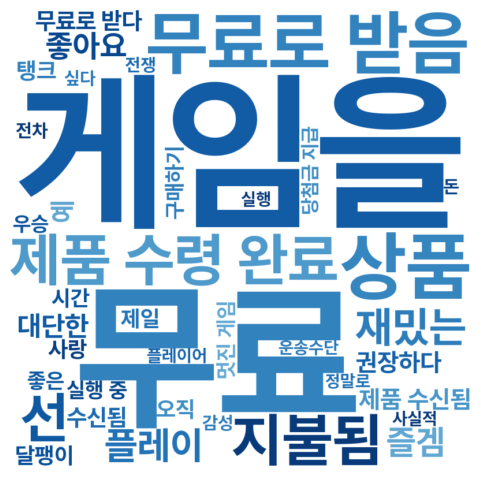

In [158]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import random, matplotlib.cm as cm
from matplotlib.colors import to_hex

# 어두운 톤만 뽑는 색 함수 정의 (Blues/Reds의 어두운 구간 사용)
blues = cm.get_cmap("Blues")

def dark_blues(*args, **kwargs):
    return to_hex(blues(random.uniform(0.50, 0.98)))  # 0.70~0.98 구간만 사용(더 진함)

# 폰트 경로 (한글 표시 필수)
fontpath='C:/Users/user/Desktop/fonts/Pretendard-Bold.ttf'


# freq 딕셔너리 만들기
freq_dict = dict(zip(pos_df_kw["keyword_ko"][:50], pos_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path=fontpath,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_blues,
    collocations=False,
    relative_scaling=0.6,
    margin=0
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6 ,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [167]:
neg_df_kw = pd.read_csv("31-5.War Thunder_부정단어.csv", encoding="utf-8-sig")

In [169]:
neg_df_kw = neg_df_kw.drop([4,7,8, 16, 26, 30,31, 33, 34, 42]).reset_index(drop=True) # 번역이 안되어서 드랍

In [170]:
neg_df_kw[:50]

,keyword_en,keyword_ko,tfidf_mean
0,game,게임을,0.047078
1,shit,염병,0.026477
2,play,플레이,0.019259
3,war,전쟁,0.017271
4,hate,증오,0.014448
5,bad,나쁨,0.013053
6,tank,전차,0.011627
7,ass,나귀,0.010801
8,just,오직,0.010119
9,want,싶다,0.009556


In [171]:
neg_df_kw["keyword_ko"] = neg_df_kw["keyword_ko"].replace({
    "새": "새로운",
    "벙기": "번지",
    "나귀": "멍청이",
    "재생 중": "실행 중",
    "선수": "플레이어",
    "층(cheung)": "스토리",
    "갈기": "빻다",
    "백성": "사람들",
    "nandigabiwo":"죽다",
    '전쟁 천둥' : 'war thunder',
    '싶다' : '원하다',
    'A점을 공격하세요！' : '공격지점',
    '전역' : '배틀',
    'gcc (가급적 gcc를 추천하지만 다른 C 컴파일러도 동작하기는 한다.)' : '폐기물(waste)'
})

C:\Users\user\AppData\Local\Temp\ipykernel_14064\440836625.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  reds  = cm.get_cmap("Reds")


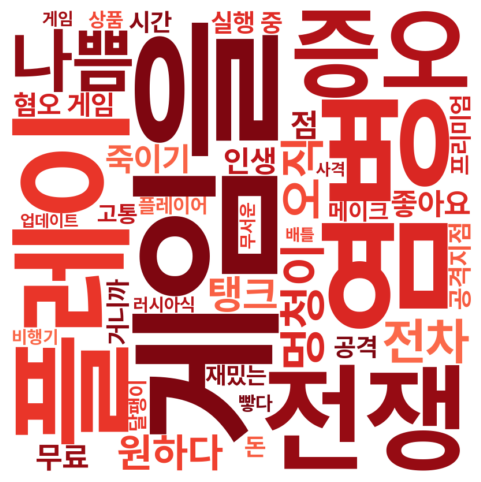

In [172]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

reds  = cm.get_cmap("Reds")

def dark_reds(*args, **kwargs):
    return to_hex(reds(random.uniform(0.50, 0.98)))

# 폰트 경로 (한글 표시 필수)
fontpath='C:/Users/user/Desktop/fonts/Pretendard-Bold.ttf'


# freq 딕셔너리 만들기
freq_dict = dict(zip(neg_df_kw["keyword_ko"][:40], neg_df_kw["tfidf_mean"][:40]))

# 워드클라우드 생성
wc = WordCloud(
    font_path=fontpath,
    width=800,
    height=800,
    background_color="white",
    color_func=dark_reds,
    collocations=False,
    relative_scaling=0.3
).generate_from_frequencies(freq_dict)

# 출력
plt.figure(figsize=(6, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()